<a href="https://colab.research.google.com/github/S61203/S61203/blob/main/speech_emotion_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
from google.colab import files
uploaded = files.upload()


Saving archive (1).zip to archive (1).zip


In [7]:
import zipfile
import os

with zipfile.ZipFile("/content/archive (1).zip", 'r') as zip_ref:
    zip_ref.extractall("/content/dataset")


In [8]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Audio
import warnings
warnings.filterwarnings('ignore')
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report


path to dataset

In [9]:
dataset_path = '/content/dataset'

# Load the dataset
paths = []
labels = []
for dirname, _, filenames in os.walk(dataset_path):
    for filename in filenames:
        if filename.endswith('.wav'):
            paths.append(os.path.join(dirname, filename))
            label = filename.split('_')[-1].split('.')[0]
            labels.append(label.lower())

print('Dataset is loaded')
print(f"Total samples: {len(paths)}")
print(paths[:5])
print(labels[:5])

Dataset is loaded
Total samples: 5600
['/content/dataset/tess toronto emotional speech set data/TESS Toronto emotional speech set data/OAF_Sad/OAF_name_sad.wav', '/content/dataset/tess toronto emotional speech set data/TESS Toronto emotional speech set data/OAF_Sad/OAF_sure_sad.wav', '/content/dataset/tess toronto emotional speech set data/TESS Toronto emotional speech set data/OAF_Sad/OAF_walk_sad.wav', '/content/dataset/tess toronto emotional speech set data/TESS Toronto emotional speech set data/OAF_Sad/OAF_pole_sad.wav', '/content/dataset/tess toronto emotional speech set data/TESS Toronto emotional speech set data/OAF_Sad/OAF_phone_sad.wav']
['sad', 'sad', 'sad', 'sad', 'sad']


create dataframe

In [10]:
df = pd.DataFrame({'speech': paths, 'label': labels})
print(df.head())

# Label distribution
print("Label distribution:")
print(df['label'].value_counts())

                                              speech label
0  /content/dataset/tess toronto emotional speech...   sad
1  /content/dataset/tess toronto emotional speech...   sad
2  /content/dataset/tess toronto emotional speech...   sad
3  /content/dataset/tess toronto emotional speech...   sad
4  /content/dataset/tess toronto emotional speech...   sad
Label distribution:
label
sad        800
angry      800
happy      800
neutral    800
fear       800
ps         800
disgust    800
Name: count, dtype: int64


Plotting label counts

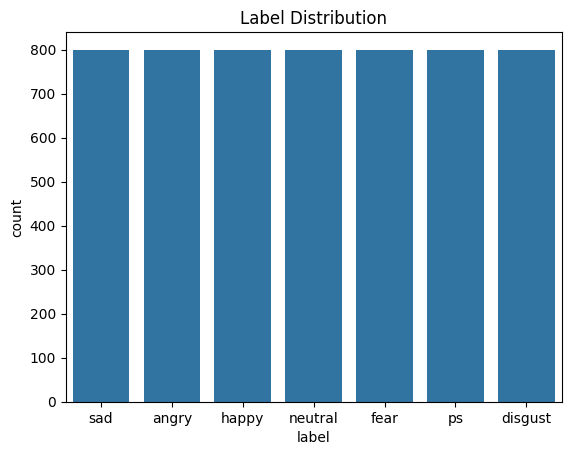

In [11]:
sns.countplot(data=df, x='label')
plt.title("Label Distribution")
plt.show()

plot waveforms and spectrograms

In [14]:
def waveplot(data, sr, emotion):
    plt.figure(figsize=(10, 4))
    plt.title(emotion, size=20)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def spectogram(data, sr, emotion):
    x = librosa.stft(data)
    xdb = librosa.amplitude_to_db(abs(x))
    plt.figure(figsize=(11, 4))
    plt.title(emotion, size=20)
    librosa.display.specshow(xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()
    plt.show()

Example of plotting for an emotion

In [13]:
emotion = 'fear'
emotion_data = df['speech'][df['label'] == emotion]

Check if there are any entries for the specified emotion

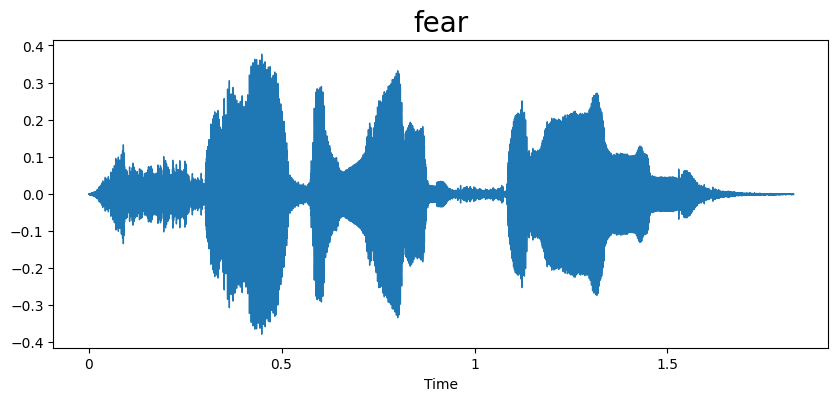

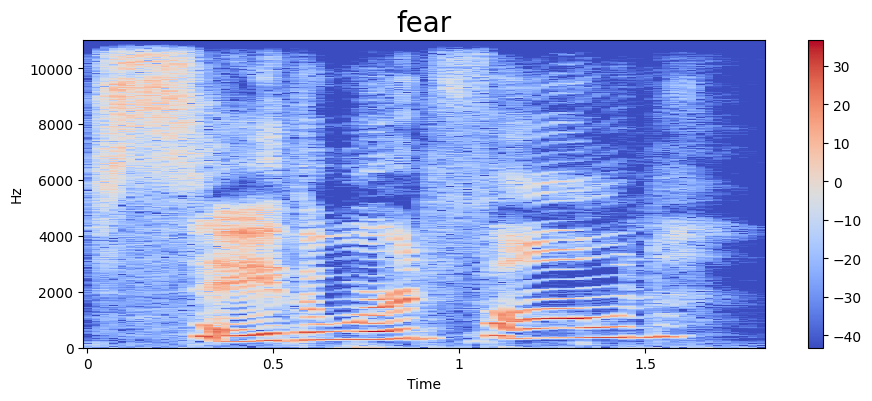

In [15]:
if len(emotion_data) > 0:
    path = np.array(emotion_data)[0]
    data, sampling_rate = librosa.load(path)
    waveplot(data, sampling_rate, emotion)
    spectogram(data, sampling_rate, emotion)
    display(Audio(path))
else:
    print(f"No data found for the emotion: {emotion}")

Feature extraction using MFCCs

In [16]:
def extract_mfcc(filename):
    y, sr = librosa.load(filename, duration=3, offset=0.5)
    mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40).T, axis=0)
    return mfcc

X_mfcc = df['speech'].apply(lambda x: extract_mfcc(x))
X = np.array([x for x in X_mfcc])
print(X.shape)


(5600, 40)


 One-hot encode the labels

In [17]:
enc = OneHotEncoder()
y = enc.fit_transform(df[['label']])
y = y.toarray()
print(y.shape)

(5600, 7)


Split data into training and validation sets

In [18]:
X = np.expand_dims(X, -1)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

Model definition

In [19]:
model = Sequential([
    LSTM(256, return_sequences=False, input_shape=(40, 1)),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(7, activation='softmax')  # Adjust output layer based on the number of unique labels
])
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 256)               264192    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 7)                 4

Train the model

In [20]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30, batch_size=64)

Epoch 1/30
70/70 [==============================] - 19s 213ms/step - loss: 1.4356 - accuracy: 0.4187 - val_loss: 0.7119 - val_accuracy: 0.7509
Epoch 2/30
70/70 [==============================] - 12s 171ms/step - loss: 0.6623 - accuracy: 0.7605 - val_loss: 0.2758 - val_accuracy: 0.9107
Epoch 3/30
70/70 [==============================] - 12s 173ms/step - loss: 0.3213 - accuracy: 0.8996 - val_loss: 0.1658 - val_accuracy: 0.9482
Epoch 4/30
70/70 [==============================] - 11s 156ms/step - loss: 0.2732 - accuracy: 0.9221 - val_loss: 0.0864 - val_accuracy: 0.9795
Epoch 5/30
70/70 [==============================] - 11s 159ms/step - loss: 0.2135 - accuracy: 0.9438 - val_loss: 0.1380 - val_accuracy: 0.9509
Epoch 6/30
70/70 [==============================] - 12s 173ms/step - loss: 0.1714 - accuracy: 0.9536 - val_loss: 0.1293 - val_accuracy: 0.9670
Epoch 7/30
70/70 [==============================] - 12s 176ms/step - loss: 0.1563 - accuracy: 0.9598 - val_loss: 0.0518 - val_accuracy: 0.9830

 Plot accuracy and loss

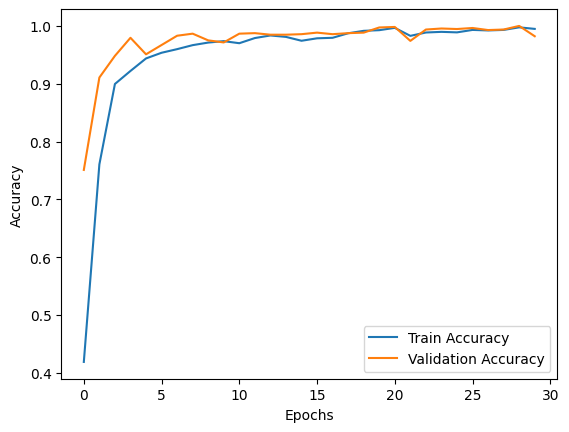

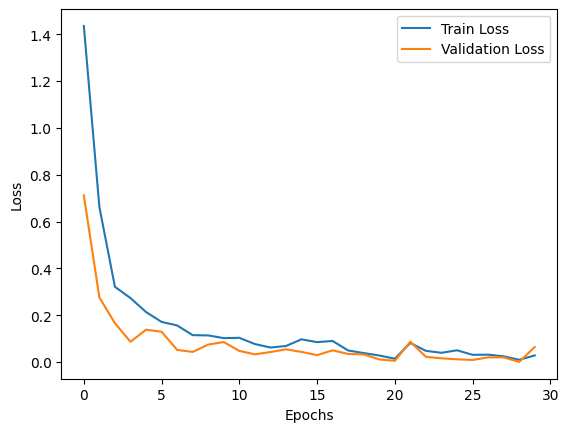

In [21]:
epochs = list(range(30))
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, acc, label='Train Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(epochs, loss, label='Train Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Predictions and evaluation

In [22]:
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_val_classes = np.argmax(y_val, axis=1)

35/35 [==============================] - 2s 32ms/step


Confusion matrix and classification report

In [23]:
conf_matrix = confusion_matrix(y_val_classes, y_pred_classes)
print("Confusion Matrix:")
print(conf_matrix)

target_names = df['label'].unique()  # Dynamically get the labels for the target names
print("Classification Report:")
print(classification_report(y_val_classes, y_pred_classes, target_names=target_names))


Confusion Matrix:
[[171   0   0   0   0   0   0]
 [  2 153   0   3   0   9   0]
 [  0   0 159   0   0   0   0]
 [  1   0   0 146   0   0   0]
 [  0   0   0   0 183   0   0]
 [  3   0   0   0   0 137   0]
 [  1   0   0   0   1   0 151]]
Classification Report:
              precision    recall  f1-score   support

         sad       0.96      1.00      0.98       171
       angry       1.00      0.92      0.96       167
       happy       1.00      1.00      1.00       159
     neutral       0.98      0.99      0.99       147
        fear       0.99      1.00      1.00       183
          ps       0.94      0.98      0.96       140
     disgust       1.00      0.99      0.99       153

    accuracy                           0.98      1120
   macro avg       0.98      0.98      0.98      1120
weighted avg       0.98      0.98      0.98      1120



 Plot confusion matrix heatmap

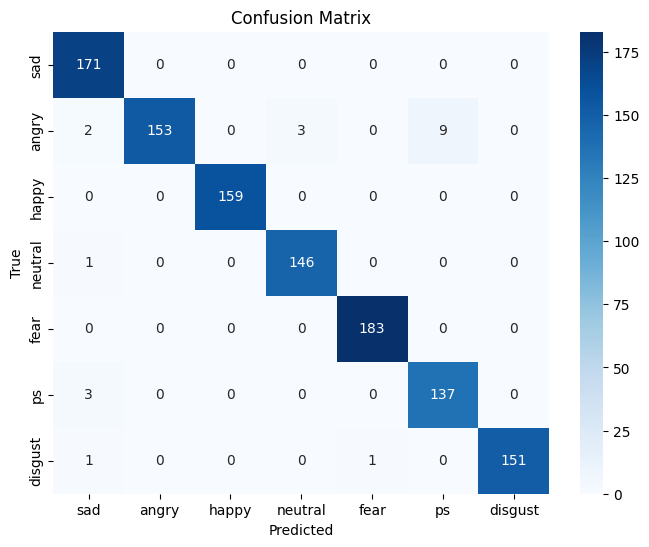

In [24]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

saving


In [25]:
model.save('model.h5')


In [26]:
model.save('saved_model')


In [27]:
from google.colab import files

files.download('model.h5')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [28]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [29]:
model.save('/content/drive/My Drive/model.h5')


In [30]:
drive.flush_and_unmount()
